## Gráficos ICE para interpretar modelos predictivos en python

## Introducción


Los gráficos Individual Conditional Expectation (ICE) y Partial Dependence (PDP) muestran cómo varían las predicciones de un modelo de machine learning en función del valor que toma alguno de sus predictores. Además de ser muy útiles para entender la relación entre la variable respuesta y los predictores, permiten diferenciar cuándo dicha relación es aditiva o está afectada por interacciones con otros predictores. También permiten entender cómo se comporta un modelo cuando se extrapola a regiones para las que no se dispone de observaciones.

Los gráficos PDP muestran, con una única curva, cómo varía en promedio la predicción de la variable respuesta a medida que se modifica uno de los predictores, manteniendo constante el resto. Los gráficos ICE muestran cómo varía la predicción para cada una de las observaciones a medida que se modifica uno de los predictores, manteniendo constante el resto. Son por lo tanto una extensión más detallada de los gráficos PDP.

Tres de las librerías que permiten crear gráficos ICE y PDP en python son sklearn.inspection, PyCEbox y PDPbox.

1. La versión de scikit-learn 0.23 solo permite la creación de gráficos PDP, la versión scikit-learn 0.24 (todavía en desarrollo en el momento de escribir este documento) sí permite crear las curvas ICE.

2. La librería PyCEbox ya no está mantenida por lo que, aunque muy fácil de utilizar, podría dejar de funcionar con futuras versiones.

3. La librería PDPbox está activamente mantenida y permite la creación de múltiples gráficos exploratorios de modelos, entre ellos, PDP e ICE.

> A lo largo de este documento se muestran ejemplos de cómo crear e interpretar gráficos ICE y PDP con la librería PDPbox.

## Curvas ICE

El set de datos Boston contiene información sobre la mediana del precio en las viviendas de la ciudad de Boston junto con información de las características de las casas y la zona donde se encuentran.

In [1]:
# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Librerías
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import plot_partial_dependence
from pdpbox import pdp, get_example, info_plots

In [9]:
# Datos
# ==============================================================================
boston = load_boston(return_X_y=False)
datos  = pd.DataFrame(boston.data, columns = boston.feature_names)
datos['MEDV'] = boston.target
datos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


> Se entrena un modelo de tipo **Random Forest** con el objetivo de predecir el precio de la vivienda (MEDV) en función de todas las demás variables disponibles.

In [10]:
# Modelo
# ==============================================================================
X_train = datos.drop(columns=['MEDV'])
y_train = datos['MEDV']

modelo = RandomForestRegressor(n_estimators=500, max_depth=4)
modelo.fit(
    X_train,
    y_train
)

RandomForestRegressor(max_depth=4, n_estimators=500)

## Curvas ICE centradas

Cuando los valores observados de la variable respuesta se acumulan en una región pequeña, el solapamiento de las curvas puede hacer difícil distinguir qué observaciones se escapan de la tendencia general. Para evitar este problema, se puede recurrir a los gráficos ICE centrados (c-ICE). Los gráficos c-ICE se obtienen igual que los gráficos ICE con la única diferencia de que, a cada una de las curvas, se les resta un valor de referencia, normalmente el valor predicho para el mínimo observado del predictor (primer valor de la curva). De esta forma, se consigue que todas las curvas tengan su origen en el 0.

Con esta nueva representación puede observarse con más claridad que, aunque la mayoría de observaciones se mantienen constantes, algunas tienen un claro patrón divergente (para algunas el precio incrementa con la antigüedad y en otras disminuye). Tal y como se describe más adelante, esto suele ser un indicativo de que el predictor AGE interacciona con otros predictores.

Una vez entrenado el modelo para obtener los gráficos ICE

> __A continuación, se explora la influencia que tiene la antigüedad de la vivienda (AGE) sobre el precio de la vivienda (MEDV).__

In [11]:
predict_AGE_MEDV = info_plots.PredictPlot(
    model=modelo,
    df=X_train,
    model_features=X_train.columns,
    feature="AGE",
    feature_name="AGE",
    pred_func=None,
    n_classes=0,
    predict_kwds={},
    chunk_size=-1,
)

obtain pred_func from the provided model.


In [12]:
fig, axes, summary_df = predict_AGE_MEDV.plot(
    figsize=None,
    ncols=2,
    plot_params={"gaps": {"inner_y": 0.05}},
    engine='plotly',
    template='plotly_white',
)
fig

In [13]:
# Cálculo curvas ICE
# ==============================================================================
ice_df = pdp.PDPIsolate(
    model=modelo,
    df=X_train,
    model_features=X_train.columns,
    feature="AGE",
    feature_name="AGE",
    n_classes=0,
    num_grid_points=20,
    grid_type='percentile'
)

obtain pred_func from the provided model.


  0%|          | 0/19 [00:00<?, ?it/s]

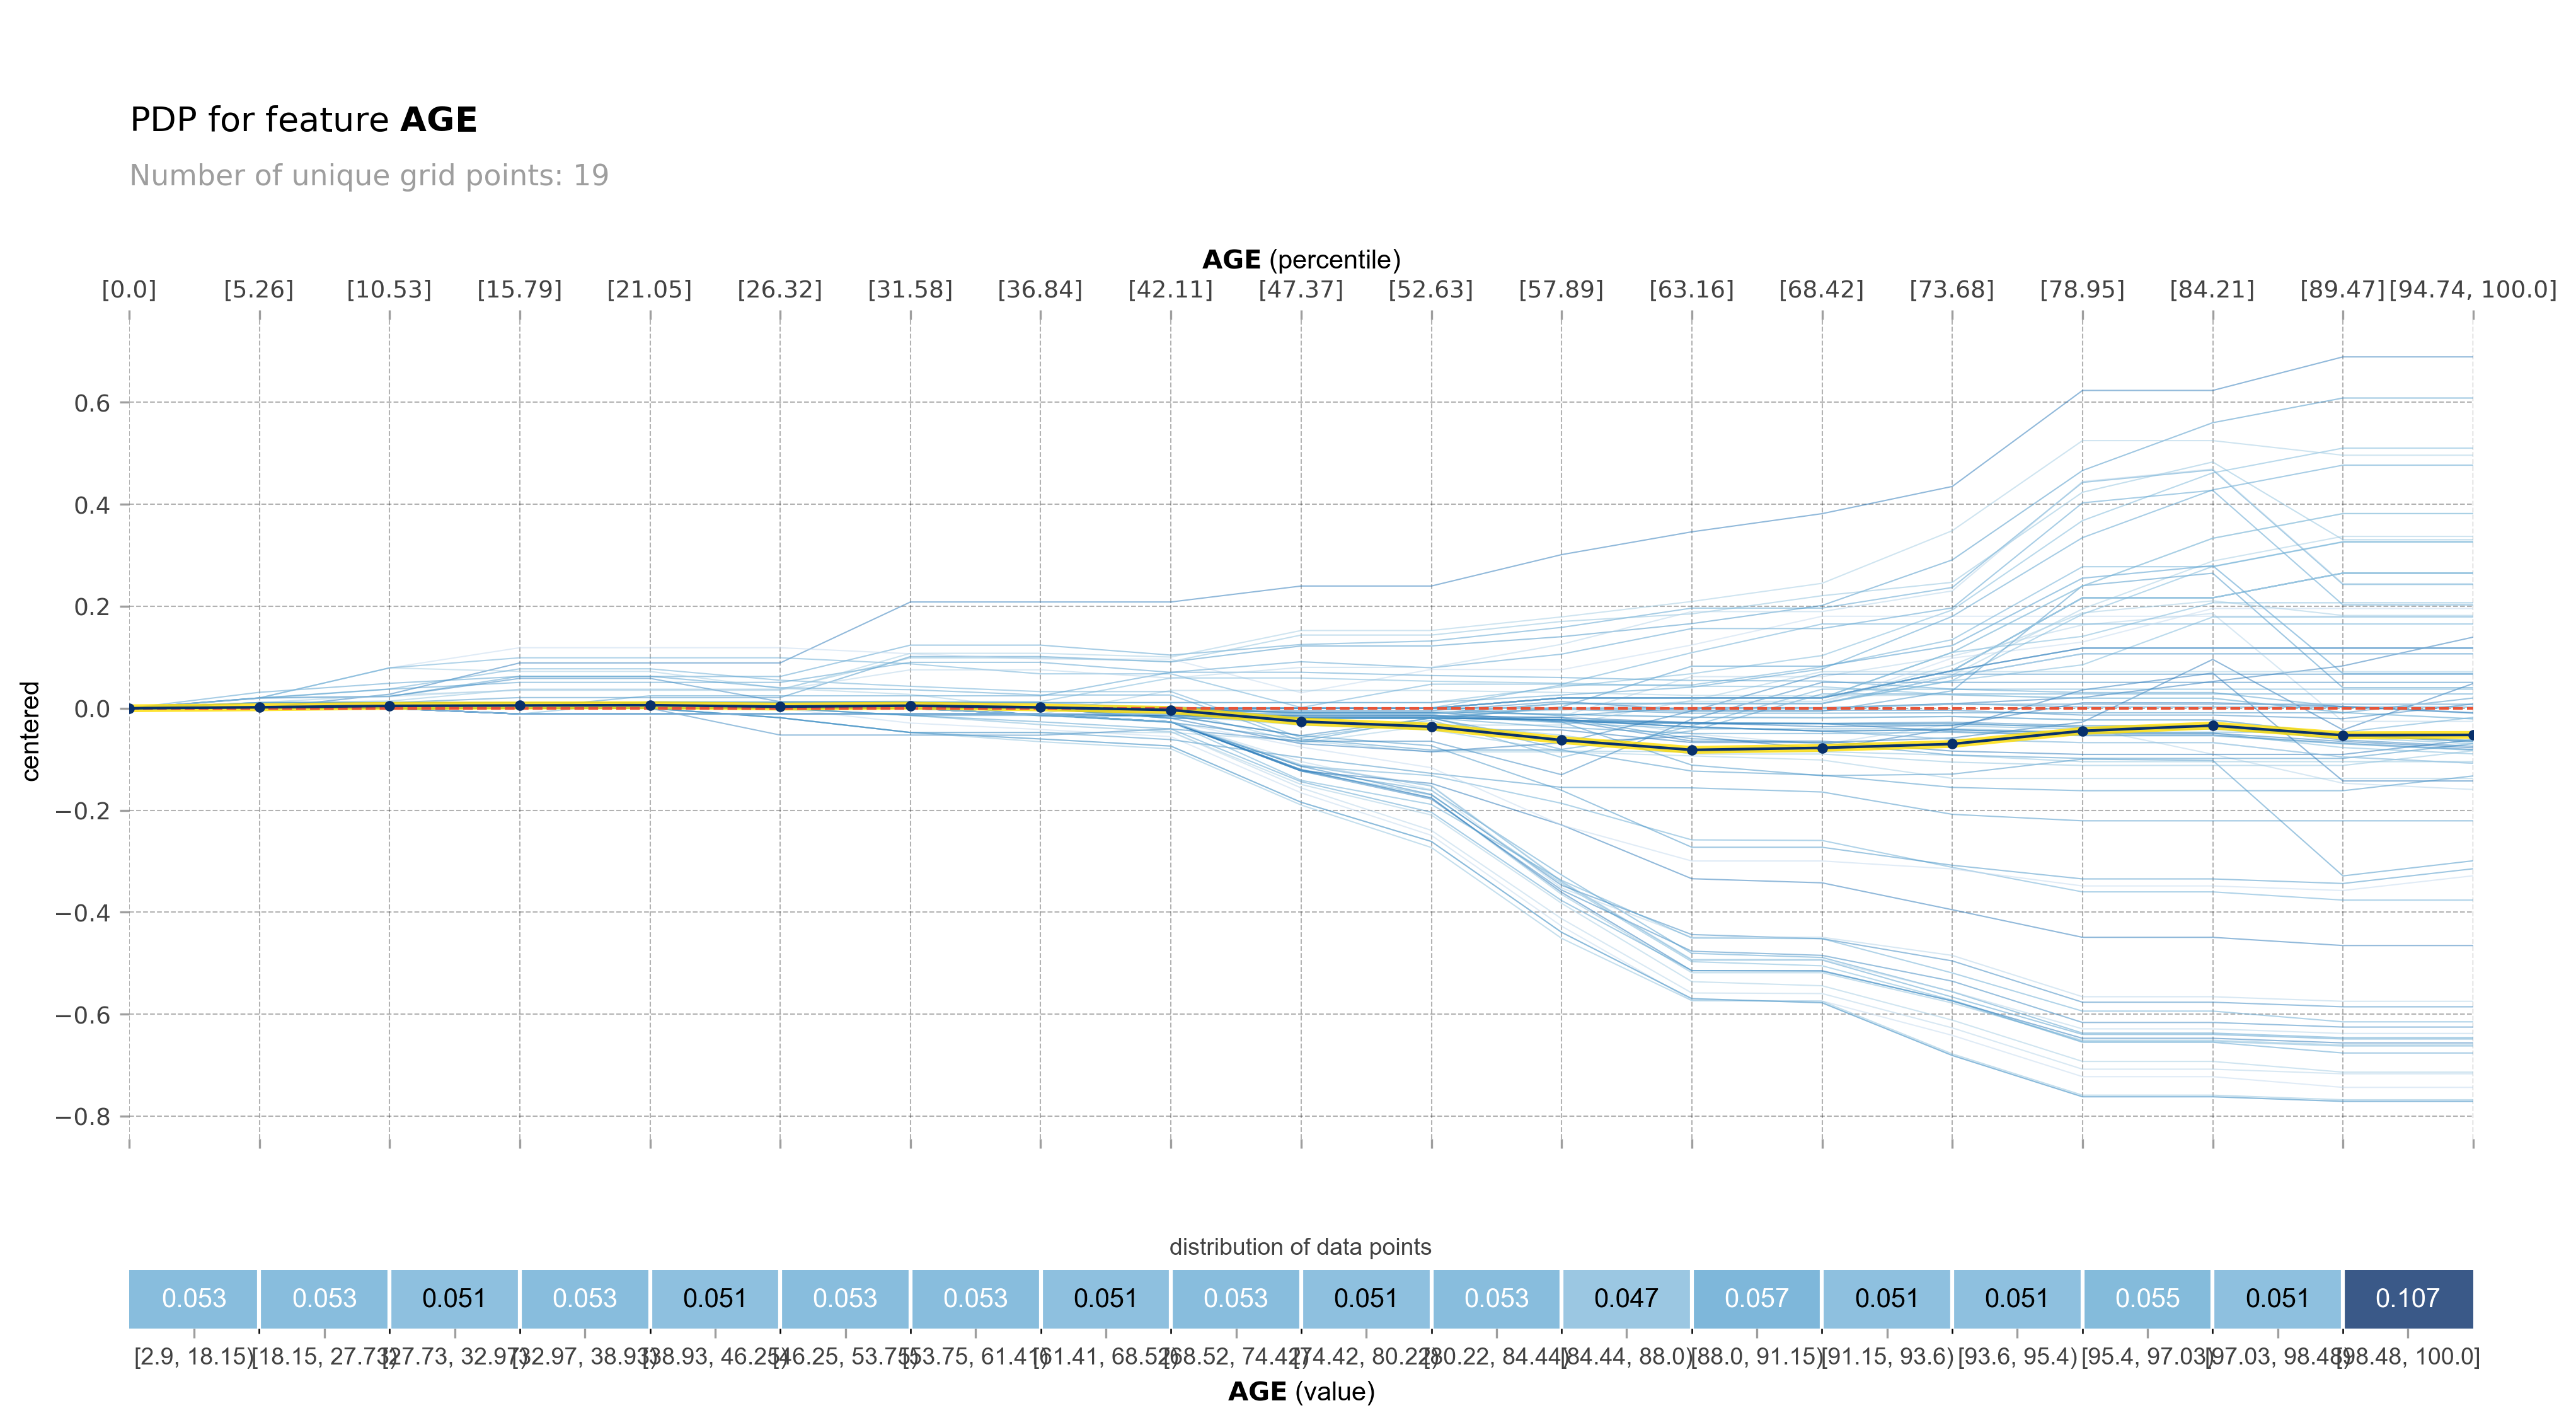

In [14]:
fig, axes = ice_df.plot(
    center=True,
    plot_lines=True,
    frac_to_plot=100,
    cluster=False,
    n_cluster_centers=None,
    cluster_method='accurate',
    plot_pts_dist=True,
    to_bins=True,
    show_percentile=True,
    which_classes=None,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params={"pdp_hl": True},
    engine='matplotlib',
    template='plotly_white',
)

In [15]:
summary_df

,x,value,percentile,count,pred_q1,pred_q2,pred_q3
0,0,"[2.9, 28.44)","[0.0, 11.11)",57,22.988311,23.710646,31.285694
1,1,"[28.44, 40.63)","[11.11, 22.22)",56,22.076916,23.076029,28.130642
2,2,"[40.63, 56.43)","[22.22, 33.33)",56,21.109126,22.212510,26.216163
3,3,"[56.43, 70.78)","[33.33, 44.44)",56,21.037915,21.886580,25.981806
4,4,"[70.78, 82.96)","[44.44, 55.56)",56,19.082548,21.171879,26.663359
5,5,"[82.96, 90.0)","[55.56, 66.67)",55,17.653364,20.879270,23.155374
6,6,"[90.0, 94.98)","[66.67, 77.78)",57,14.887708,17.874924,21.063903
7,7,"[94.98, 98.3)","[77.78, 88.89)",55,14.349974,16.059013,20.904319
8,8,"[98.3, 100.0]","[88.89, 100.0]",58,11.347889,14.266428,18.301911
